# **Consistent Non-Annotated Train-Validation Split**

- Just splitting the training data now, so that there is consistency between all the other stages of the training and feature extraction process
- It will be a 75-25 split of the training data

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage

In [2]:
# Variabels to be reused
path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/audio_files' 
npy_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/train_audio_npy/' 
train_csv = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/train-not-annotated.csv' 
annotated_train_csv = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/train-annotated.csv'
sr = 22050

In [3]:
df_train = pd.read_csv(train_csv) # Reading in training data
df_train.head()

,Unnamed: 0,species,audio_name,duration,filename_npy
0,0,Ciconia ciconia,XC171088.mp3,32.470204,Ciconia ciconia/XC171088.npy
1,1,Alcedo atthis,XC503772.mp3,9.195102,Alcedo atthis/XC503772.npy
2,2,Himantopus himantopus,XC154289.mp3,30.484898,Himantopus himantopus/XC154289.npy
3,3,Motacilla flava,XC281358.mp3,30.746122,Motacilla flava/XC281358.npy
4,4,Acrocephalus melanopogon,XC406576.mp3,202.448980,Acrocephalus melanopogon/XC406576.npy


In [4]:
df_train['species'].value_counts()

species
Alcedo atthis                49
Himantopus himantopus        45
Porphyrio porphyrio          42
Acrocephalus melanopogon     41
Gallinula chloropus          40
Fulica atra                  35
Botaurus stellaris           34
Tachybaptus ruficollis       34
Ardea purpurea               33
Charadrius alexandrinus      33
Dendrocopos minor            32
Motacilla flava              31
Acrocephalus arundinaceus    29
Ciconia ciconia              28
Ixobrychus minutus           27
Acrocephalus scirpaceus      25
Circus aeruginosus           24
Coracias garrulus            14
Anas platyrhynchos           12
Anas strepera                 7
Name: count, dtype: int64

In [6]:
filepaths = df_train['filename_npy']

## Get the durations for all the species

In [7]:
duration_sum = df_train.groupby('species', as_index=False)['duration'].sum()
duration_sum['duration_mins'] = duration_sum['duration'] / 60
duration_sum = duration_sum.sort_values('duration', ascending=False)
duration_sum.head(20)

,species,duration,duration_mins
0,Acrocephalus arundinaceus,3995.692925,66.594882
2,Acrocephalus scirpaceus,3038.140771,50.635680
1,Acrocephalus melanopogon,2722.573605,45.376227
12,Dendrocopos minor,2567.182630,42.786377
17,Motacilla flava,1864.797052,31.079951
3,Alcedo atthis,1836.926122,30.615435
15,Himantopus himantopus,1812.916009,30.215267
7,Botaurus stellaris,1698.335329,28.305589
18,Porphyrio porphyrio,1401.324354,23.355406
10,Circus aeruginosus,1183.091519,19.718192


# Do a 75-25 training and validation split for each species so enough intraspecies sample variation

In [8]:
shuffled_train = df_train.sample(frac=1, random_state=1814) # shuffle the original df before splitting to train/val

In [21]:
def intraspecies_split(df, split_ratio=0.8):
    train_data = pd.DataFrame() 
    val_data = pd.DataFrame()    
    
    # Group by 'species' and split within each species
    for species in df['species'].unique():
        species_df = df[df['species'] == species].copy()
        
        species_df = species_df.sample(frac=1, random_state=6220).reset_index(drop=True)
        train, val = train_test_split(species_df, train_size=split_ratio, random_state=14)
        
        # Concatenate the result back into the main train and validation dataframes
        train_data = pd.concat([train_data, train])
        val_data = pd.concat([val_data, val])
    
    # Reset the index of the final dataframes
    train_data = train_data.reset_index(drop=True)
    val_data = val_data.reset_index(drop=True)
    
    return train_data, val_data

In [22]:
# Doing the intraspecies split
train_df, val_df = intraspecies_split(shuffled_train)

In [23]:
# Check the results
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))

Training set size: 485
Validation set size: 130


### Confirm no duplicates and the samples in validation set are not in the training set

In [24]:
assert len(val_df) == val_df['filename_npy'].nunique()

In [25]:
assert len(train_df) == train_df['filename_npy'].nunique()

In [26]:
is_present = val_df['filename_npy'].isin(train_df['filename_npy']).any()

assert not is_present, "Validation set contains samples from training set!"

### Combining the training and validation sets into one set with a column identifying the set the samples belong to

In [27]:
train_df['set'] = 'tr'
val_df['set'] = 'val'

merged_train = pd.concat([train_df, val_df])

In [28]:
# Grouping by 'species' and 'set', summing durations
duration_sum = merged_train[['species', 'duration', 'set']].groupby(['species', 'set'], as_index=False).sum()
duration_sum['duration_mins'] = duration_sum['duration'] / 60
duration_sum = duration_sum.sort_values('species', ascending=False)
duration_sum.head(40)


,species,set,duration,duration_mins
39,Tachybaptus ruficollis,val,295.586032,4.926434
38,Tachybaptus ruficollis,tr,860.194558,14.336576
37,Porphyrio porphyrio,val,97.117052,1.618618
36,Porphyrio porphyrio,tr,1304.207302,21.736788
35,Motacilla flava,val,318.812925,5.313549
34,Motacilla flava,tr,1545.984127,25.766402
33,Ixobrychus minutus,val,165.823129,2.763719
32,Ixobrychus minutus,tr,1002.459546,16.707659
30,Himantopus himantopus,tr,1362.158957,22.702649
31,Himantopus himantopus,val,450.757052,7.512618


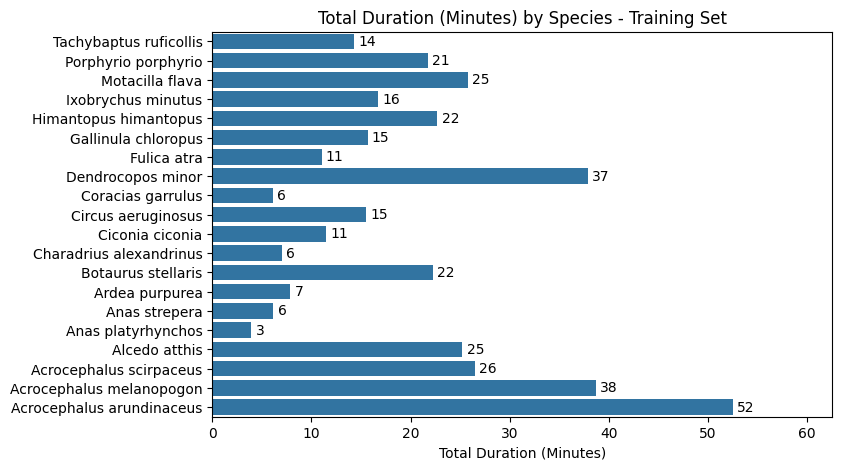

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

sns.barplot(x='duration_mins', y='species', data=duration_sum[duration_sum['set'] =='tr'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='tr']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Training Set')

plt.show()

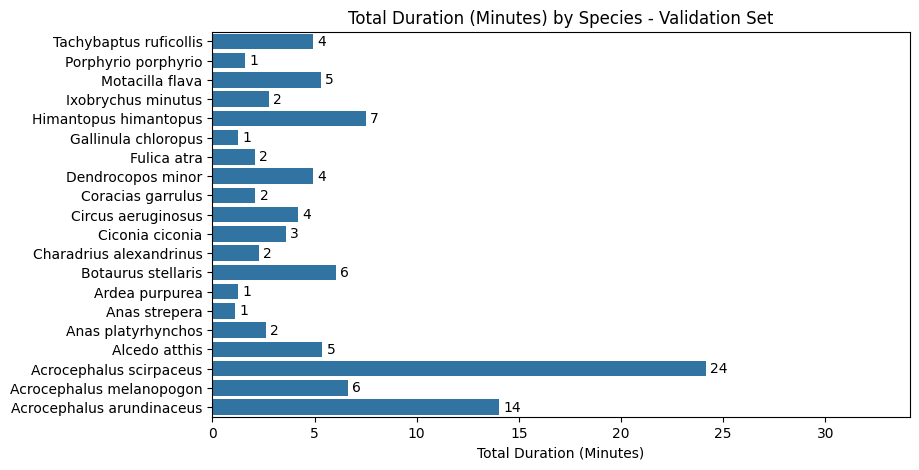

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,5))

sns.barplot(x='duration_mins', y='species', data=duration_sum[duration_sum['set'] =='val'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='val']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Validation Set')

plt.show()

In [32]:
merged_train.to_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/trainval-split/trainval.csv', index=False)

In [33]:
merged_train

,Unnamed: 0,species,audio_name,duration,filename_npy,set
0,602,Acrocephalus melanopogon,XC542357.mp3,37.955918,Acrocephalus melanopogon/XC542357.npy,tr
1,195,Acrocephalus melanopogon,XC360704.mp3,18.796553,Acrocephalus melanopogon/XC360704.npy,tr
2,116,Acrocephalus melanopogon,XC213784.mp3,75.455782,Acrocephalus melanopogon/XC213784.npy,tr
3,596,Acrocephalus melanopogon,XC358629.mp3,40.449161,Acrocephalus melanopogon/XC358629.npy,tr
4,219,Acrocephalus melanopogon,XC357368.mp3,86.232018,Acrocephalus melanopogon/XC357368.npy,tr
...,...,...,...,...,...,...
125,110,Ciconia ciconia,XC518425.mp3,7.039546,Ciconia ciconia/XC518425.npy,val
126,117,Ciconia ciconia,XC149045.mp3,22.079229,Ciconia ciconia/XC149045.npy,val
127,161,Ciconia ciconia,XC149071.mp3,60.300499,Ciconia ciconia/XC149071.npy,val
128,588,Anas strepera,XC210379.mp3,5.940000,Anas strepera/XC210379.npy,val
